<a href="https://colab.research.google.com/github/OctaviaCosby/AI-Image-Detector/blob/main/Capstone_Project_AI_Art_Image_Detector_Octavia_Cosby.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EfficientNetB0 Model

### Import the libraries

In [ ]:
!pip install tensorflow_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 117.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.3 MB/s eta 0:00:00


In [ ]:
pip install tf_keras

In [ ]:
!pip install tensorflow numpy matplotlib opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.1 MB/s eta 0:00:00


In [ ]:
#import the libraries
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
# import os
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, roc_curve

### Unzip the folder & prep dataset through reprocessing



In [ ]:
#unzip file
import zipfile

with zipfile.ZipFile("/content/imagedataset.zip", "r") as dataset:
  dataset.extractall("/content/imagedataset/")

### prep dataset using efficientnet preprocessing

In [ ]:
#create function to resize rescale images
def process_image_enb0(image, label):
    image = tf.image.resize(image, [224, 224])
    image = preprocess_input(image)
    return image, label

train_detector_enb0 = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/imagedataset/imagedataset/dataset/",
    image_size=(224, 224),
    batch_size=32,
    seed = 123,
    subset = "training",
    validation_split = 0.2)

validation_detector_enb0 = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/imagedataset/imagedataset/dataset/",
    image_size=(224, 224),
    batch_size=32,
    seed = 123,
    subset = "validation",
    validation_split = 0.2)

#view names of classes
print("Class names:", train_detector_enb0.class_names)

Found 1076 files belonging to 2 classes.
Using 861 files for training.
Found 1076 files belonging to 2 classes.
Using 215 files for validation.
Class names: ['AiArtData', 'RealArt']


### reprocess and optimize pipeline

In [ ]:
#image data pipeline using tensor flow
AUTOTUNE_b0 = tf.data.AUTOTUNE

#rescale, augment and process images adding autotune buffer size for better optimization
train_detector_enb0 = train_detector_enb0.map(process_image_enb0).prefetch(AUTOTUNE_b0)
validation_detector_enb0  = validation_detector_enb0.map(process_image_enb0).prefetch(AUTOTUNE_b0)

### Load the base model

In [ ]:
#load the base
base = EfficientNetB0(weights="imagenet",
                      include_top=False,
                      input_shape=(224, 224, 3)
                      )
base.trainable= False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Create the parameters for custom model

In [ ]:
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.4)(x)
x = Dense(128, activation = "relu")(x)
x = Dropout(0.2)(x)
outputlayer = Dense(1, activation = "sigmoid")(x)

detector_enb0 = Model(inputs=base.input, outputs=outputlayer)

### Create the model

In [ ]:
#compile
detector_enb0.compile(optimizer="adam",
                      loss="binary_crossentropy",
                      metrics=['accuracy'])

detector_enb0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Train the Model

In [ ]:
history_enb0 = detector_enb0.fit(train_detector_enb0,
                                 epochs=100,
                                 validation_data=validation_detector_enb0
                                 )

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 449ms/step - accuracy: 0.9946 - loss: 0.0329 - val_accuracy: 0.7907 - val_loss: 0.6251
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 476ms/step - accuracy: 0.9857 - loss: 0.0378 - val_accuracy: 0.7814 - val_loss: 0.6320
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 458ms/step - accuracy: 0.9889 - loss: 0.0374 - val_accuracy: 0.7721 - val_loss: 0.7266
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 444ms/step - accuracy: 0.9922 - loss: 0.0295 - val_accuracy: 0.7907 - val_loss: 0.6948
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 450ms/step - accuracy: 0.9817 - loss: 0.0494 - val_accuracy: 0.7814 - val_loss: 0.6539
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 465ms/step - accuracy: 0.9846 - loss: 0.0384 - val_accuracy: 0.7814 - val_loss: 0.7152
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 449ms/step - accuracy: 0.9835 - loss: 0.0421 - val_accuracy: 0.7953 - val_loss: 0.6599
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 464ms/step - accuracy: 0.9874 - loss: 0.0372 - 

In [ ]:
#view keys for plots
print(history_enb0.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [ ]:
#plot accuracy vs validation accuracy before fine tuning

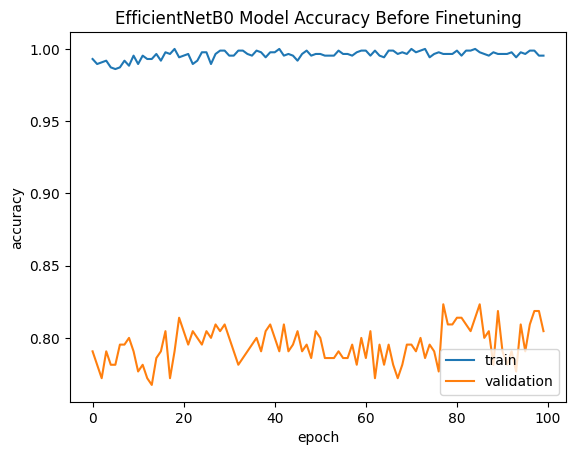

In [ ]:
plt.plot(history_enb0.history['accuracy'])
plt.plot(history_enb0.history['val_accuracy'])
plt.title("EfficientNetB0 Model Accuracy Before Finetuning")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc = "lower right")
plt.show()

### Loss Before Finetuning

<function matplotlib.pyplot.show(close=None, block=None)>

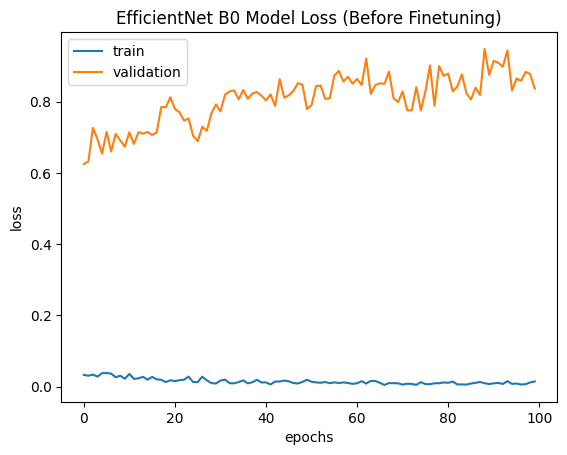

In [ ]:
plt.plot(history_enb0.history['loss'])
plt.plot(history_enb0.history['val_loss'])
plt.title("EfficientNet B0 Model Loss (Before Finetuning)")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["train", "validation"], loc="upper left")
plt.show


### Fine tune the model

In [ ]:
base.trainable = True

detector_enb0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])

history_finetune_enb0= detector_enb0.fit(train_detector_enb0, epochs=10, validation_data = validation_detector_enb0)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 593ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.8047 - val_loss: 0.8374
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 480ms/step - accuracy: 0.9988 - loss: 0.0075 - val_accuracy: 0.8047 - val_loss: 0.8375
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 465ms/step - accuracy: 0.9983 - loss: 0.0049 - val_accuracy: 0.8047 - val_loss: 0.8375
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 466ms/step - accuracy: 0.9977 - loss: 0.0121 - val_accuracy: 0.8047 - val_loss: 0.8381
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 449ms/step - accuracy: 0.9983 - loss: 0.0090 - val_accuracy: 0.8047 - val_loss: 0.8386
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 440ms/step - accuracy: 0.9975 - loss: 0.0070 - val_accuracy: 0.8047 - val_loss: 0.8380
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.8047 - val_loss: 0.8375
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 441ms/step - accuracy: 0.9988 - loss: 0.0049 - val_accu

### model evaluation

In [ ]:
val_loss, val_accuracy = detector_enb0.evaluate(validation_detector_enb0)
print(f"Validation Accuracy: {val_accuracy:.7f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 355ms/step - accuracy: 0.8242 - loss: 0.6369
Validation Accuracy: 0.8046511


### Plot accuracy after fine tuning

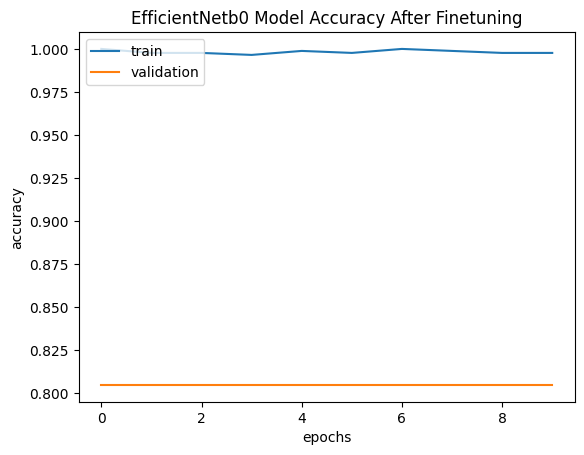

In [ ]:
plt.plot(history_finetune_enb0.history['accuracy'])
plt.plot(history_finetune_enb0.history['val_accuracy'])
plt.title("EfficientNetb0 Model Accuracy After Finetuning")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["train", "validation"], loc = "upper left")
plt.show()

### Plot Loss After Finetuning

<function matplotlib.pyplot.show(close=None, block=None)>

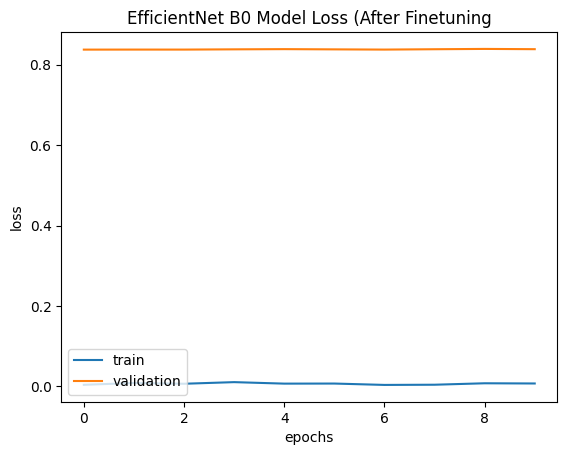

In [ ]:
plt.plot(history_finetune_enb0.history['loss'])
plt.plot(history_finetune_enb0.history['val_loss'])
plt.title("EfficientNet B0 Model Loss (After Finetuning")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["train", "validation"], loc="lower left")
plt.show

### Test on new images

In [ ]:
import cv2

In [ ]:
def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224))
  img = preprocess_input(img)
  img= np.expand_dims(img, axis=0)
  #percentage of decision accuracy
  prediction_percent = detector_enb0.predict(img)[0][0]

  if prediction_percent >= 0.5:
    label = "Class 1 (Little to No AI Generation)"
  else:
    label = "Class 0 (Moderate to Substantial AI Generation)"

  return f"Prediction: {prediction_percent:.5f} {label}"

image_path= "aibdaycake.jpg"
result = predict_image(image_path)
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: 0.99999 Class 1 (Little to No AI Generation)


In [ ]:
def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224))
  img = preprocess_input(img)
  img= np.expand_dims(img, axis=0)
  #percentage of decision accuracy
  prediction_percent = detector_enb0.predict(img)[0][0]

  if prediction_percent >= 0.5:
    label = "Class 1 (Little to No AI Generation)"
  else:
    label = "Class 0 (Moderate to Substantial AI Generation)"

  return f"Prediction: {prediction_percent:.5f} {label}"

image_path= "birthdaycake.jpg"
result = predict_image(image_path)
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Prediction: 0.99920 Class 1 (Little to No AI Generation)


In [ ]:
def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224))
  img = preprocess_input(img)
  img= np.expand_dims(img, axis=0)
  #percentage of decision accuracy
  prediction_percent = detector_enb0.predict(img)[0][0]

  if prediction_percent >= 0.5:
    label = "Class 1 (Little to No AI Generation)"
  else:
    label = "Class 0 (Moderate to Substantial AI Generation)"

  return f"Prediction: {prediction_percent:.5f} {label}"

image_path= "ai-gen-portrait.jpg"
result = predict_image(image_path)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Prediction: 0.80674 Class 1 (Little to No AI Generation)


In [ ]:
def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224))
  img = preprocess_input(img)
  img= np.expand_dims(img, axis=0)
  #percentage of decision accuracy
  prediction_percent = detector_enb0.predict(img)[0][0]

  if prediction_percent >= 0.5:
    label = "Class 1 (Little to No AI Generation)"
  else:
    label = "Class 0 (Moderate to Substantial AI Generation)"

  return f"Prediction: {prediction_percent:.5f} {label}"

image_path= "mona-lisa.jpg"
result = predict_image(image_path)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Prediction: 1.00000 Class 1 (Little to No AI Generation)


In [ ]:
def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224))
  img = preprocess_input(img)
  img= np.expand_dims(img, axis=0)
  #percentage of decision accuracy
  prediction_percent = detector_enb0.predict(img)[0][0]

  if prediction_percent >= 0.5:
    label = "Class 1 (Little to No AI Generation)"
  else:
    label = "Class 0 (Moderate to Substantial AI Generation)"

  return f"Prediction: {prediction_percent:.5f} {label}"

image_path= "/content/ai-headshot-male.jpg"
result = predict_image(image_path)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Prediction: 0.03476 Class 0 (Moderate to Substantial AI Generation)


In [ ]:
def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224))
  img = preprocess_input(img)
  img= np.expand_dims(img, axis=0)
  #percentage of decision accuracy
  prediction_percent = detector_enb0.predict(img)[0][0]

  if prediction_percent >= 0.5:
    label = "Class 1 (Little to No AI Generation)"
  else:
    label = "Class 0 (Moderate to Substantial AI Generation)"

  return f"Prediction: {prediction_percent:.5f} {label}"

image_path= "headshot-male.jpg"
result = predict_image(image_path)
print(result)

### Calsulate the accuracy

### Make prediction

In [ ]:
#get labels

y_true_enb0 = np.concatenate([y for x, y in validation_detector_enb0], axis=0)

y_pred_prob_enb0 = detector_enb0.predict(validation_detector_enb0)

y_pred_enb0 = (y_pred_prob_enb0 > 0.5).astype(int).reshape(-1)

#F1 score
f1_enb0 = f1_score(y_true_enb0, y_pred_enb0)
print(f"F-1 Score: {f1_enb0}")

#recall score
recall_enb0 = recall_score(y_true_enb0, y_pred_enb0)
print(f"Recall Score: {recall_enb0}")

#aucroc
auc_enb0 = roc_auc_score(y_true_enb0, y_pred_enb0)
print(f"AUC-ROC: {auc_enb0}")

#precision score
precision_enb0 = precision_score(y_true_enb0, y_pred_enb0)
print(f"Precision Score: {precision_enb0}")

#confusion matrix
conf_matrix = confusion_matrix(y_true_enb0, y_pred_enb0)
print(f"Confusion Matrix:")
print(conf_matrix)

In [ ]:
#predictions vs true
for images, labels in validation_detector_enb0.take(1):
    preds = detector_enb0.predict(images)
    preds = (preds > 0.5).astype(int)

    plt.figure(figsize=(12, 6))

    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = labels[i].numpy()
        pred_label = preds[i][0]
        plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.show()


### ROC Curve Plot

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true_enb0, y_pred_enb0)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_enb0:.2f})', color="orange")
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel("False Postivite Rate")
plt.ylabel("True Positive Rate")
plt.title("EfficientNetB0: Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="upper left")
plt.show()

## VGG16

### reprocessing for VGG16

In [ ]:
#preprocessing for VGG16
def process_image_vgg16(image, label):
    image = preprocess_input(image)
    return image, label

In [ ]:
#load dataset image_dataset_from_directory
train_detector_vgg16 = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/imagedataset/imagedataset/dataset/",
    image_size=(224, 224),
    batch_size=32,
    seed=123,
    subset="training",
    validation_split=0.2
)

validation_detector_vgg16 = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/imagedataset/imagedataset/dataset/",
    image_size=(224, 224),
    batch_size=32,
    seed=123,
    subset="validation",
    validation_split=0.2
)


train_detector_vgg16 = train_detector_vgg16.map(process_image_vgg16)
validation_detector_vgg16 = validation_detector_vgg16.map(process_image_vgg16)


Found 1076 files belonging to 2 classes.
Using 861 files for training.
Found 1076 files belonging to 2 classes.
Using 215 files for validation.


### Set up model

In [ ]:
#build vgg model
base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.4)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
output = Dense(1, activation="sigmoid")(x)

detector_vgg16 = Model(inputs=base.input, outputs=output)



> Add blockquote



In [ ]:
#comipler for model
detector_vgg16.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

### Feature extraction/ training of model

In [ ]:
#train the model through feature extraction
history_vgg16 = detector_vgg16.fit(
    train_detector_vgg16,
    epochs=100,
    validation_data=validation_detector_vgg16
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 788ms/step - accuracy: 0.5786 - loss: 2.3542 - val_accuracy: 0.7070 - val_loss: 1.0509
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 716ms/step - accuracy: 0.7175 - loss: 1.2979 - val_accuracy: 0.7302 - val_loss: 0.8992
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 708ms/step - accuracy: 0.7333 - loss: 1.0880 - val_accuracy: 0.7581 - val_loss: 0.6807
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 698ms/step - accuracy: 0.7941 - loss: 0.7016 - val_accuracy: 0.7721 - val_loss: 0.5504
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 708ms/step - accuracy: 0.7721 - loss: 0.6246 - val_accuracy: 0.7488 - val_loss: 0.5816
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 699ms/step - accuracy: 0.7528 - loss: 0.6321 - val_accuracy: 0.7674 - val_loss: 0.5017
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 708ms/step - accuracy: 0.7802 - loss: 0.5812 - val_accuracy: 0.7535 - val_loss: 0.5050
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 699ms/step - accuracy: 0.7579 - loss: 0.5602 - 

### Validation accuracy before finetune

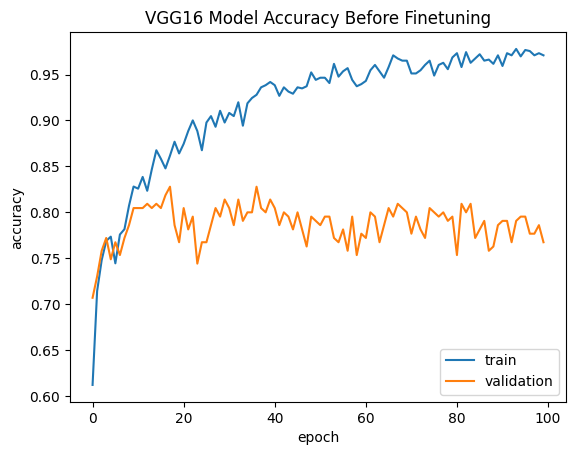

In [ ]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title("VGG16 Model Accuracy Before Finetuning")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc = "lower right")
plt.show()

### Plot Loss before finetuning

<function matplotlib.pyplot.show(close=None, block=None)>

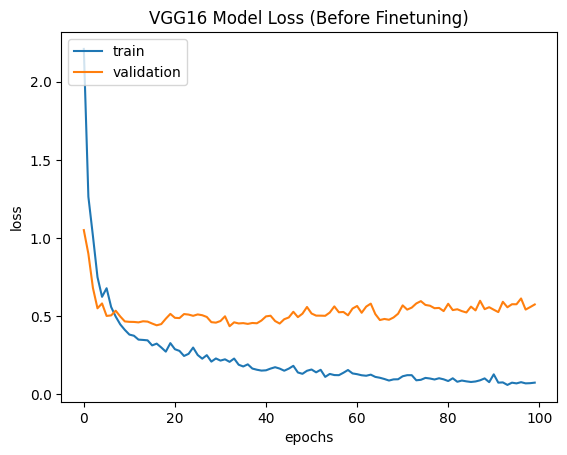

In [ ]:
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title("VGG16 Model Loss (Before Finetuning)")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["train", "validation"], loc="upper left")
plt.show

### Finetune the model

In [ ]:
#unfreeze the layers
base.trainable = True
detector_vgg16.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

#finetune the model
history_finetune_vgg16 = detector_vgg16.fit(
    train_detector_vgg16,
    epochs=10,
    validation_data=validation_detector_vgg16
)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.9572 - loss: 0.1252 - val_accuracy: 0.7814 - val_loss: 0.6362
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step - accuracy: 0.9715 - loss: 0.0852 - val_accuracy: 0.7907 - val_loss: 0.6074
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 122s 5s/step - accuracy: 0.9801 - loss: 0.0589 - val_accuracy: 0.7907 - val_loss: 0.5692
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step - accuracy: 0.9772 - loss: 0.0643 - val_accuracy: 0.7953 - val_loss: 0.5725
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step - accuracy: 0.9816 - loss: 0.0541 - val_accuracy: 0.8047 - val_loss: 0.5256
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step - accuracy: 0.9785 - loss: 0.0502 - val_accuracy: 0.8093 - val_loss: 0.5306
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - accuracy: 0.9900 - loss: 0.0371 - val_accuracy: 0.8000 - val_loss: 0.7778
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - accuracy: 0.9881 - loss: 0.0463 - val_accuracy: 0.7767 - v

### Evaluate accuracy

In [ ]:
#calc validation accuracy
val_loss, val_accuracy = detector_vgg16.evaluate(validation_detector_vgg16)
print(f"Validation Accuracy: {val_accuracy:.7f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 555ms/step - accuracy: 0.7964 - loss: 0.5457
Validation Accuracy: 0.8000000


### Plot val accuracy after finetuning

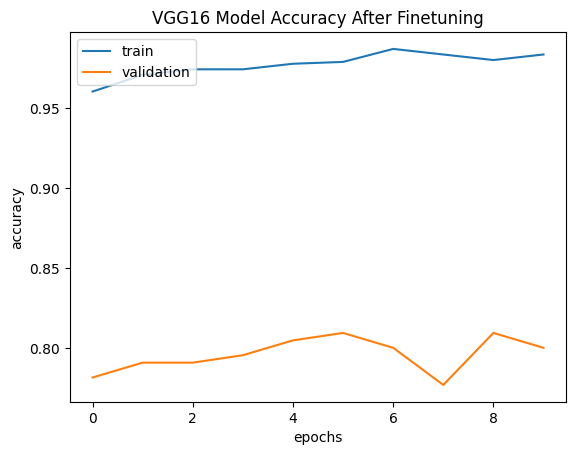

In [ ]:
plt.plot(history_finetune_vgg16.history['accuracy'])
plt.plot(history_finetune_vgg16.history['val_accuracy'])
plt.title("VGG16 Model Accuracy After Finetuning")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["train", "validation"], loc = "upper left")
plt.show()

### Plot loss after finetuning

<function matplotlib.pyplot.show(close=None, block=None)>

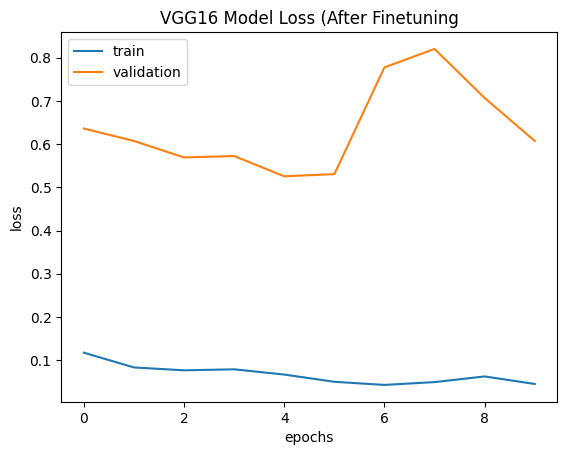

In [ ]:
plt.plot(history_finetune_vgg16.history['loss'])
plt.plot(history_finetune_vgg16.history['val_loss'])
plt.title("VGG16 Model Loss (After Finetuning")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["train", "validation"], loc="upper left")
plt.show

### Test on new images

In [ ]:
import cv2

def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224))
  img = preprocess_input(img)
  img= np.expand_dims(img, axis=0)
  #percentage of decision accuracy
  prediction_percent = detector_vgg16.predict(img)[0][0]

  if prediction_percent >= 0.5:
    label = "Class 1 (Little to No AI Generation)"
  else:
    label = "Class 0 (Moderate to Substantial AI Generation)"

  return f"Prediction: {prediction_percent:.5f} {label}"

image_path= "aibdaycake.jpg"
result = predict_image(image_path)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Prediction: 0.08359 Class 0 (Moderate to Substantial AI Generation)


In [ ]:
def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224))
  img = preprocess_input(img)
  img= np.expand_dims(img, axis=0)
  #percentage of decision accuracy
  prediction_percent = detector_vgg16.predict(img)[0][0]

  if prediction_percent >= 0.5:
    label = "Class 1 (Little to No AI Generation)"
  else:
    label = "Class 0 (Moderate to Substantial AI Generation)"

  return f"Prediction: {prediction_percent:.5f} {label}"

image_path= "birthdaycake.jpg"
result = predict_image(image_path)
print(result)

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [ ]:
def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224))
  img = preprocess_input(img)
  img= np.expand_dims(img, axis=0)
  #percentage of decision accuracy
  prediction_percent = detector_vgg16.predict(img)[0][0]

  if prediction_percent >= 0.5:
    label = "Class 1 (Little to No AI Generation)"
  else:
    label = "Class 0 (Moderate to Substantial AI Generation)"

  return f"Prediction: {prediction_percent:.5f} {label}"

image_path= "ai-gen-portrait.jpg"
result = predict_image(image_path)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Prediction: 0.69751 Class 1 (Little to No AI Generation)


In [ ]:
def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224))
  img = preprocess_input(img)
  img= np.expand_dims(img, axis=0)
  #percentage of decision accuracy
  prediction_percent = detector_vgg16.predict(img)[0][0]

  if prediction_percent >= 0.5:
    label = "Class 1 (Little to No AI Generation)"
  else:
    label = "Class 0 (Moderate to Substantial AI Generation)"

  return f"Prediction: {prediction_percent:.5f} {label}"

image_path= "mona-lisa.jpg"
result = predict_image(image_path)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Prediction: 0.99969 Class 1 (Little to No AI Generation)


In [ ]:
def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224))
  img = preprocess_input(img)
  img= np.expand_dims(img, axis=0)
  #percentage of decision accuracy
  prediction_percent = detector_vgg16.predict(img)[0][0]

  if prediction_percent >= 0.5:
    label = "Class 1 (Little to No AI Generation)"
  else:
    label = "Class 0 (Moderate to Substantial AI Generation)"

  return f"Prediction: {prediction_percent:.5f} {label}"

image_path= "ai-headshot-male.jpg"
result = predict_image(image_path)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Prediction: 0.99997 Class 1 (Little to No AI Generation)


In [ ]:
def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224))
  img = preprocess_input(img)
  img= np.expand_dims(img, axis=0)
  #percentage of decision accuracy
  prediction_percent = detector_vgg16.predict(img)[0][0]

  if prediction_percent >= 0.5:
    label = "Class 1 (Little to No AI Generation)"
  else:
    label = "Class 0 (Moderate to Substantial AI Generation)"

  return f"Prediction: {prediction_percent:.5f} {label}"

image_path= "headshot-male.jpg"
result = predict_image(image_path)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Prediction: 1.00000 Class 1 (Little to No AI Generation)


### Evaluate metrics

In [ ]:
#get labels

y_true_vgg16 = np.concatenate([y.numpy() for x, y in validation_detector_vgg16], axis=0)

y_pred_prob_vgg16 = detector_vgg16.predict(validation_detector_vgg16)

y_pred_vgg16 = (y_pred_prob_vgg16 > 0.5).astype(int).reshape(-1)

#F1 score
f1_vgg16 = f1_score(y_true_vgg16, y_pred_vgg16)
print(f"F-1 Score: {f1_vgg16}")

#recall score
recall_vgg16 = recall_score(y_true_vgg16, y_pred_vgg16)
print(f"Recall Score: {recall_vgg16}")

#aucroc
auc_vgg16 = roc_auc_score(y_true_vgg16, y_pred_vgg16)
print(f"AUC-ROC: {auc_vgg16}")

#precision score
precision_vgg16 = precision_score(y_true_vgg16, y_pred_vgg16)
print(f"Precision Score: {precision_vgg16}")

#confusion matrix
conf_matrix = confusion_matrix(y_true_vgg16, y_pred_vgg16)
print(f"Confusion Matrix:")
print(conf_matrix)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 565ms/step
F-1 Score: 0.4307692307692308
Recall Score: 0.4375
AUC-ROC: 0.47925420168067223
Precision Score: 0.42424242424242425
Confusion Matrix:
[[62 57]
 [54 42]]


### ROC-AUC PLOT

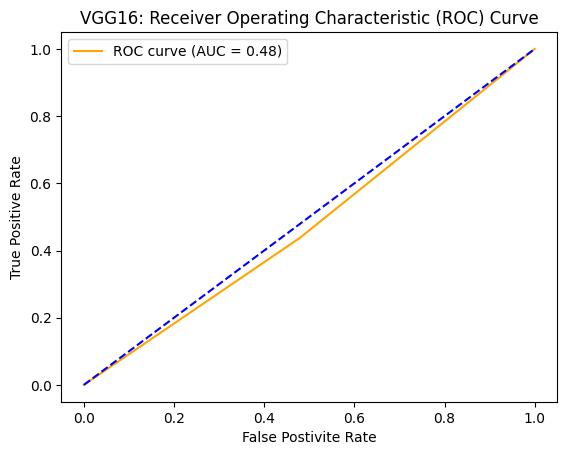

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true_vgg16, y_pred_vgg16)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_vgg16:.2f})', color="orange")
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel("False Postivite Rate")
plt.ylabel("True Positive Rate")
plt.title("VGG16: Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="upper left")
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 551ms/step
F1 Score: 0.441025641025641
Recall: 0.4479166666666667
Precision: 0.43434343434343436
AUC-ROC: 0.48866421568627455
Confusion Matrix:
[[63 56]
 [53 43]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


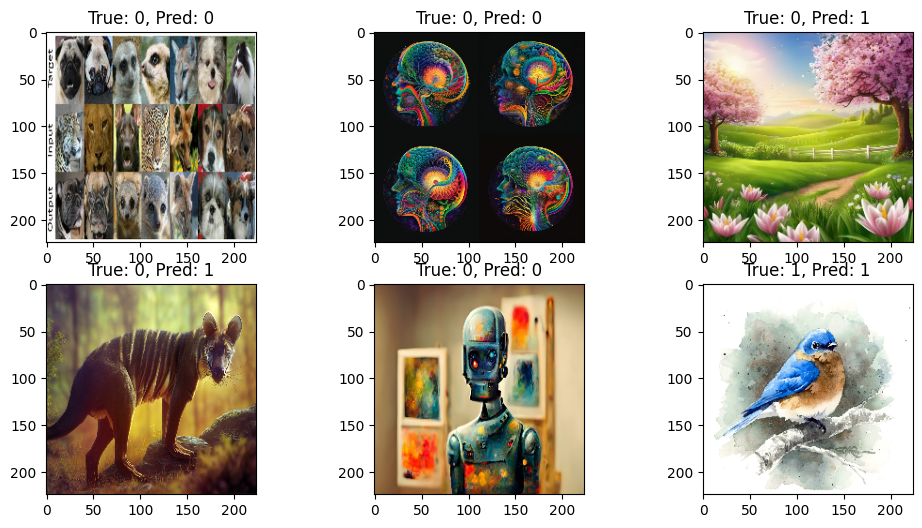

In [ ]:


#get true labels and predictions
y_true_vgg16 = np.concatenate([y for x, y in validation_detector_vgg16], axis=0)

y_pred_prob_vgg16 = detector_vgg16.predict(validation_detector_vgg16)

y_pred_vgg16 = (y_pred_prob_vgg16 > 0.5).astype(int).reshape(-1)

#measurements
f1_vgg16 = f1_score(y_true_vgg16, y_pred_vgg16)
print(f"F1 Score: {f1_vgg16}")

recall_vgg16 = recall_score(y_true_vgg16, y_pred_vgg16)
print(f"Recall: {recall_vgg16}")

precision_vgg16 = precision_score(y_true_vgg16, y_pred_vgg16)
print(f"Precision: {precision_vgg16}")

auc_vgg16 = roc_auc_score(y_true_vgg16, y_pred_vgg16)
print(f"AUC-ROC: {auc_vgg16}")

conf_matrix = confusion_matrix(y_true_vgg16, y_pred_vgg16)
print("Confusion Matrix:")
print(conf_matrix)







for images, labels in validation_detector_vgg16.take(1):
    preds = detector_vgg16.predict(images)
    preds = (preds > 0.5).astype(int)

    plt.figure(figsize=(12, 6))
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = labels[i].numpy()
        pred_label= preds[i][0]
        plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.show()


### EfficientNetB3



In [ ]:
#load the base
base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base.trainable= False

In [ ]:
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.4)(x)
x = Dense(128, activation = "relu")(x)
x = Dropout(0.2)(x)
outputlayer = Dense(1, activation = "sigmoid")

In [ ]:
detector_vgg16 = Model(inputs=base.input, outputs=outputlayer(x))

#compile
detector_vgg16.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

detector_vgg16.summary()

In [ ]:
#unzip file
import zipfile

with zipfile.ZipFile("/content/imagedataset.zip", "r") as dataset:
  dataset.extractall("/content/imagedataset/")

train_detector_vgg16 = tf.keras.preprocessing.image_dataset_from_directory("/content/imagedataset/imagedataset/dataset/", image_size=(224, 224), batch_size=32, seed = 123, subset = "training", validation_split = 0.2)

validation_detector_vgg16 = tf.keras.preprocessing.image_dataset_from_directory("/content/imagedataset/imagedataset/dataset/", image_size=(224, 224), batch_size=32, seed = 123, subset = "validation", validation_split = 0.2)

In [ ]:
#image data pipeline using tensor flow data
AUTOTUNE_vgg16 = tf.data.AUTOTUNE

#create function to resize rescale images
def process_image_vgg16(image, label):
    image = preprocess_input(image)
    return image, label

  #rescale, augment and process images
train_detector_vgg16 = train_detector_vgg16.map(process_image_enb0)
validation_detector_vgg16  = validation_detector_vgg16.map(process_image_enb0)

In [ ]:
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.4)(x)
x = Dense(128, activation = "relu")(x)
x = Dropout(0.2)(x)
outputlayer = Dense(1, activation = "sigmoid")

In [ ]:
#rescale, augment and process images
train_detector_vgg16 = train_detector_vgg16.map(process_image_vgg16)
validation_detector_vgg16 = validation_detector_vgg16 .map(process_image_vgg16)

In [ ]:
#adding autotune buffer size for better performance
train_detector_vgg16 = train_detector_vgg16.cache().prefetch(buffer_size=AUTOTUNE_vgg16)
validation_detector_vgg16 = validation_detector_vgg16.cache().prefetch(buffer_size=AUTOTUNE_vgg16)

In [ ]:
#rescale and normalize data
datagen_train_vgg16 = ImageDataGenerator(rescale = 1.0/255, rotation_range = 30, width_shift_range = 0.2, height_shift_range = 0.2, zoom_range = 0.2, horizontal_flip = True, validation_split= 0.2)


In [ ]:
#train the model
history_vgg16 = detector_vgg16.fit(train_detector_vgg16, epochs=100, validation_data=validation_detector_vgg16)

In [ ]:
print(history_enb0.history.keys())

In [ ]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title("VGG16 Model Accuracy Before Finetuning")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc = "upper left")
plt.show()

In [ ]:
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title("VGG16 Model Loss (Before Finetuning)")
plt.xlabel("loss")
plt.ylabel("epochs")
plt.legend(["train", "validation"], loc="upper left")
plt.show

#### fine-tuning

In [ ]:
base.trainable = True

detector_vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])

history_finetune_vgg16= detector_vgg16.fit(train_detector_vgg16, epochs=10, validation_data = validation_detector_vgg16)

Model Evaluation Accuracy

In [ ]:
val_loss, val_accuracy = detector_vgg16.evaluate(validation_detector_vgg16)
print(f"Validation Accuracy: {val_accuracy:.7f}")

In [ ]:
plt.plot(history_finetune_vgg16.history['accuracy'])
plt.plot(history_finetune_vgg16.history['val_accuracy'])
plt.title("VGG16 Model Accuracy After Finetuning")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["train", "validation"], loc = "upper left")
plt.show()

In [ ]:
plt.plot(history_finetune_vgg16.history['loss'])
plt.plot(history_finetune_vgg16.history['val_loss'])
plt.title("VGG16 Model Loss (After Finetuning")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["train", "validation"], loc="lower left")
plt.show

### Test on new images

In [ ]:
def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224)) / 255.0
  img= np.expand_dims(img, axis=0)
  prediction_percent = detector_vgg16.predict(img)[0][0]
  prediction = detector_vgg16.predict(img)
  return f"Prediction: {prediction_percent:.5f}" + \
  (" Class 1 (Contains Substantial AI Generation)" if prediction >= 0.5 else "Class 0 (Contains Little to No AI Genertion)")

image_path= "aibdaycake.jpg"
result = predict_image(image_path)
print(result)

### VGG Model Evaluation

In [ ]:
#get labels

y_true_vgg16 = np.concatenate([y for x, y in validation_detector_vgg16], axis=0)

y_pred_prob_vgg16 = detector_vgg16.predict(validation_detector_vgg16)

y_pred_vgg16 = (y_pred_prob_vgg16 > 0.5).astype(int).reshape(-1)

#F1 score
f1_vgg16 = f1_score(y_true_vgg16, y_pred_vgg16)
print(f"F-1 Score: {f1_vgg16}")

#recall score
recall_vgg16 = recall_score(y_true_vgg16, y_pred_vgg16)
print(f"Recall Score: {recall_vgg16}")

#aucroc
auc_vgg16 = roc_auc_score(y_true_vgg16, y_pred_vgg16)
print(f"AUC-ROC: {auc_vgg16}")

#precision score
precision_vgg16 = precision_score(y_true_vgg16, y_pred_vgg16)
print(f"Precision Score: {precision_vgg16}")

#confusion matrix
conf_matrix = confusion_matrix(y_true_vgg16, y_pred_vgg16)
print(f"Confusion Matrix:")
print(conf_matrix)

In [ ]:
detector_enb3 = Model(inputs=base.input, outputs=outputlayer(x))

#compile
detector_enb3.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

detector_enb3.summary()

In [ ]:
#image data pipeline using tensor flow data
AUTOTUNE_b = tf.data.AUTOTUNE

#create function to resize rescale images
def process_image_enb0(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

  #rescale, augment and process images
train_detector_enb0 = train_detector_enb0.map(process_image_enb0)
validation_detector_enb0  = validation_detector_enb0.map(process_image_enb0)

In [ ]:
train_detector_enb3 = datagen_train_enb3.flow_from_directory("/content/imagedataset/imagedataset/dataset/", target_size=(224, 224), batch_size=32, class_mode = "binary", subset = "training")

validation_detector_enb3 = datagen_train_enb3.flow_from_directory("/content/imagedataset/imagedataset/dataset/", target_size=(224, 224), batch_size=32, class_mode = "binary", subset = "validation")

In [ ]:
history_enb3 = detector_enb3.fit(train_detector_enb3, epochs=100, validation_data = validation_detector_enb3)

Plot the accuracy before finetuning

In [ ]:
plt.plot(history_enb3.history['accuracy'])
plt.plot(history_enb3.history['val_accuracy'])
plt.title("EfficientNetB3 Model Accuracy Before Finetuning")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "validation"], loc = "upper left")
plt.show()

### plot loss before finetuning

In [ ]:
plt.plot(history_enb3.history['loss'])
plt.plot(history_enb3.history['val_loss'])
plt.title("EfficientNet B3 Model Loss (Before Finetuning)")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["train", "validation"], loc="upper right")
plt.show


### Fine tune the model (b3)

In [ ]:
base.trainable = True

detector_enb3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])

history_finetune_enb3= detector_enb3.fit(train_detector_enb3, epochs=5, validation_data = validation_detector_enb3)

### Accuracy after finetuning

In [ ]:
val_loss_enb3, val_accuracy_enb3 = detector_enb3.evaluate(validation_detector_enb3)
print(f"Validation Accuracy: {val_accuracy_enb3:.7f}")

### plot the accuracy after finetuning

In [ ]:
plt.plot(history_finetune_enb3.history['accuracy'])
plt.plot(history_finetune_enb3.history['val_accuracy'])
plt.title("EfficientNetB3 Model Accuracy After Finetuning")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["train", "validation"], loc = "upper left")
plt.show()

### Plot loss after finetuning

In [ ]:
plt.plot(history_finetune_enb3.history['loss'])
plt.plot(history_finetune_enb3.history['val_loss'])
plt.title("EfficientNet B3 Model Loss (After Finetuning)")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["train", "validation"], loc="upper left")
plt.show

### Test model on new images

In [ ]:
import cv2
def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224)) / 255.0
  img= np.expand_dims(img, axis=0)
  prediction = detector_enb3.predict(img)
  return "Class 1 (Little to No AI Generation)" if prediction > 0.5 else "Class 0 (Contains Substastantial AI Generation)"

image_path= "aibdaycake.jpg"
result = predict_image(image_path)
print(result)


In [ ]:
import cv2
def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224)) / 255.0
  img= np.expand_dims(img, axis=0)
  prediction = detector_enb3.predict(img)
  return "Class 1 (Little to No AI Generation)" if prediction > 0.5 else "Class 0 (Contains Substastantial AI Generation)"

image_path= "/content/skyandplamtrees.jpg"
result = predict_image(image_path)
print(result)

### Calculate accuracy of model

In [ ]:
#get labels
y_true_enb3 = validation_detector_enb3.classes

y_pred_prob_enb3 = detector_enb3.predict(validation_detector_enb3)

y_pred_enb3 = (y_pred_prob_enb3 > 0.5).astype(int).reshape(-1)

#F1 score
f1_enb3 = f1_score(y_true_enb3, y_pred_enb3)
print(f"F-1 Score: {f1_enb3}")

#recall score
recall_enb3 = recall_score(y_true_enb3, y_pred_enb3)
print(f"Recall Score: {recall_enb3}")

#aucroc
auc_enb3 = roc_auc_score(y_true_enb3, y_pred_enb3)
print(f"AUC-ROC: {auc_enb3}")

#precision score
precision_enb3 = precision_score(y_true_enb3, y_pred_enb3)
print(f"Precision Score: {precision_enb3}")

#confusion matrix
conf_matrix_enb3 = confusion_matrix(y_true_enb3, y_pred_enb3)
print(f"Confusion Matrix:")
print(conf_matrix_enb3)

### ROC Curve Plot

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true_enb3, y_pred_enb3)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_enb3:.2f})', color="orange")
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel("False Postivite Rate")
plt.ylabel("True Positive Rate")
plt.title("EfficientNetB3: Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="upper left")
plt.show()

# EfficientnetV2S

In [ ]:
#load the base
base = tf.keras.applications.EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base.trainable = False

In [ ]:
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.4)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
output = Dense(1, activation="sigmoid")(x)

In [ ]:
from tensorflow.keras.optimizers import Adam
detector_env2s = Model(inputs=base.input, outputs=outputlayer(x))

#compile
detector_env2s.compile(optimizer=Adam(learning_rate=1e-4),loss='binary_crossentropy', metrics=['accuracy'])

detector_env2s.summary()

In [ ]:
#rescale and normalize data
datagen_train_env2s = ImageDataGenerator(rescale = 1.0/255, rotation_range = 30, width_shift_range = 0.2, height_shift_range = 0.2, zoom_range = 0.2, horizontal_flip = True, validation_split= 0.2)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the base EfficientNetV2S model
base = tf.keras.applications.EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base.trainable = False  # Freeze the convolutional base

# Build custom head
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.4)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
output = Dense(1, activation="sigmoid")(x)  # Binary classification

# Define the model
detector_env2s = Model(inputs=base.input, outputs=output)

# Compile the model
detector_env2s.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

detector_env2s.summary()

# Set up image data pipeline using tf.data
AUTOTUNE = tf.data.AUTOTUNE

# Function to process images (resize, rescale, etc.)
def process_image(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0  # Rescale images to [0, 1]
    return image, label

# Load the dataset (use your own directory)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/imagedataset/imagedataset/dataset/",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/imagedataset/imagedataset/dataset/",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Process images (data augmentation and rescaling) on the fly
train_ds = train_ds.map(process_image)
val_ds = val_ds.map(process_image)

# Cache and prefetch data for better performance
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Train the model
history_env2s = detector_env2s.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds
)

In [ ]:
print(train_ds.class_names)

In [ ]:
train_detector_env2s = datagen_train_env2s.flow_from_directory("/content/imagedataset/imagedataset/dataset/", target_size=(224, 224), batch_size=32, class_mode = "binary", subset = "training")

validation_detector_env2s = datagen_train_env2s.flow_from_directory("/content/imagedataset/imagedataset/dataset/", target_size=(224, 224), batch_size=32, class_mode = "binary", subset = "validation")

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# history_env2s = detector_env2s.fit(train_detector_env2s, epochs=100, validation_data = validation_detector_env2s, use_multiprocessing=True, shuffle=True, verbrose=1)

### Plot accuracy before finetuning

In [ ]:
plt.plot(history_env2s.history['accuracy'])
plt.plot(history_env2s.history['val_accuracy'])
plt.title("EfficientNetV2S Model Accuracy Before Finetuning")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "validation"], loc = "upper left")
plt.show()

### Plot loss before finetuning

In [ ]:
plt.plot(history_env2s.history['loss'])
plt.plot(history_env2s.history['val_loss'])
plt.title("EfficientNetV2s Model Loss (Before Finetuning)")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["train", "validation"], loc="upper left")
plt.show

### Finetune the model (V2S)

In [ ]:
base.trainable = True

detector_env2s.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])

history_finetune_env2s= detector_env2s.fit(train_detector_env2s, epochs=5, validation_data = val_ds)

### Accuracy after finetuning

In [ ]:
val_loss_env2s, val_accuracy_env2s = detector_env2s.evaluate(validation_detector_env2s)
print(f"Validation Accuracy: {val_accuracy_env2s:.7f}")

### Plot the accuracy after finetuning

In [ ]:
plt.plot(history_finetune_env2s.history['accuracy'])
plt.plot(history_finetune_env2s.history['val_accuracy_env2s'])
plt.title("EfficientNetV2S Model Accuracy After Finetuning")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["train", "validation"], loc = "upper left")
plt.show()

### Plot loss after finetuning

In [ ]:
plt.plot(history_finetune_env2s.history['loss'])
plt.plot(history_finetune_env2s.history['val_loss_env2s'])
plt.title("EfficientNetv2s Model Loss (After Finetuning)")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["train", "validation"], loc="upper left")
plt.show

### Test model on new images

In [ ]:
import cv2
def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224)) / 255.0
  img= np.expand_dims(img, axis=0)
  prediction = detector_env2s.predict(img)
  return "Class 0 (Contains AI generation)" if prediction > 0.5 else "Class 1 (Little to No AI generation detected)"

image_path= "aibdaycake.jpg"
result = predict_image(image_path)
print(result)

Real portrait

In [ ]:
import cv2
def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224)) / 255.0
  img= np.expand_dims(img, axis=0)
  prediction = detector_env2s.predict(img)
  return "Class 1 (Contains AI generation)" if prediction > 0.5 else "Class 0 (Little to No AI generation detected)"

image_path= "/content/skyandplamtrees.jpg"
result = predict_image(image_path)
print(result)

### Calculate the accuracy and additional scores of the model

In [ ]:
#get labels
y_true_env2s = validation_detector_env2s.classes

y_pred_prob_env2s = detector_env2s.predict(validation_detector_env2s)

y_pred_env2s = (y_pred_prob_env2s > 0.5).astype(int).reshape(-1)

#F1 score
f1_env2s = f1_score(y_true_env2s, y_pred_env2s)
print(f"F-1 Score: {f1_env2s}")

#recall score
recall_env2s = recall_score(y_true_env2s, y_pred_env2s)
print(f"Recall Score: {recall_env2s}")

#aucroc
auc_env2s = roc_auc_score(y_true_env2s, y_pred_env2s)
print(f"AUC-ROC: {auc_env2s}")

#precision score
precision_env2s = precision_score(y_true_env2s, y_pred_env2s)
print(f"Precision Score: {precision_env2s}")

#confusion matrix
conf_matrix_env2s = confusion_matrix(y_true_env2s, y_pred_env2s)
print(f"Confusion Matrix:")
print(conf_matrix_env2s)

### Plot ROC Curve

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true_env2s, y_pred_env2s)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_env2s:.2f})', color="orange")
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel("False Postivite Rate")
plt.ylabel("True Positive Rate")
plt.title("EfficientNetV2S: Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="upper left")
plt.show()

## VGG16 Model

In [ ]:
#rescale and normalize data
datagen_train_enb0 = ImageDataGenerator(rescale = 1.0/255, rotation_range = 30, width_shift_range = 0.2, height_shift_range = 0.2, zoom_range = 0.2, horizontal_flip = True, validation_split= 0.2)

In [ ]:
dataset_path = "/content/imagedataset/imagedataset/dataset/"

In [ ]:
#validation split 80/20 split
data_gen_vgg= ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

In [ ]:
#load training data
train_data_vgg = data_gen_vgg.flow_from_directory(directory = dataset_path, target_size=(224, 224), batch_size=32, class_mode= "binary", subset = "training", shuffle=True)

test_data_vgg = data_gen_vgg.flow_from_directory(directory = dataset_path, target_size=(224, 224), batch_size=32, class_mode="binary", subset = "validation", shuffle = False)

### create an object for training and testing data

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

detector_vgg = Sequential()
detector_vgg.add(Conv2D(input_shape=(224, 224,3), filters=64, kernel_size=(3,3), padding="same", activation="relu"))
detector_vgg.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation = "relu"))
detector_vgg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
detector_vgg.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
detector_vgg.add(Conv2D(filters = 128, kernel_size=(3,3), padding="same", activation="relu"))
detector_vgg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
detector_vgg.add(Conv2D(filters=256, kernel_size=(3,3), padding = "same", activation = "relu"))
detector_vgg.add(Conv2D(filters=256, kernel_size=(3, 3), padding = "same", activation ="relu"))
detector_vgg.add(Conv2D(filters=256, kernel_size=(3,3), padding = "same", activation="relu"))
detector_vgg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
detector_vgg.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
detector_vgg.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation ="relu"))
detector_vgg.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation = "relu"))
detector_vgg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
detector_vgg.add(Conv2D(filters=512, kernel_size=(3,3), padding= "same", activation = "relu"))
detector_vgg.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation = "relu"))
detector_vgg.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation = "relu"))
detector_vgg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))


#initialize the model
detector_vgg.add(Flatten())
detector_vgg.add(Dense(units=4096, activation="relu"))
detector_vgg.add(Dense(units=4096, activation="relu"))
detector_vgg.add(Dense(units=2, activation="softmax"))
detector_vgg.add(Dense(units=1, activation ="sigmoid"))

#### compile model

In [ ]:
from keras.optimizers import Adam

optim = Adam(learning_rate=0.001)
detector_vgg.compile(optimizer=optim, loss = "binary_crossentropy", metrics=['accuracy'])

detector_vgg.summary()

### Using TFRecord Dataset for VGG-16

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
image_size = (224, 224)
batch_size = 32
autotune = tf.data.AUTOTUNE
classes = 2

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
check_point = ModelCheckpoint("vgg16_1.h5", monitor="validation_accuracy", verbose=1, save_best_only=True, save_weights_only=False, mode="auto", save_freq="epoch")
early_stop = EarlyStopping(monitor="validation_accuracy", min_delta=0, patience=20, verbose=1, mode="max")
history = detector_vgg.fit(steps_per_epoch=100, x=train_data_vgg, validation_data = test_data_vgg, validation_steps = 10, epochs = 10, callbacks=[check_point, early_stop])

### Testing Accuracy

In [ ]:
val_loss, val_accuracy = detector_vgg.evaluate(validation_detector_vgg)
print(f"Validation Accuracy: {val_accuracy:.7f}")

In [ ]:
#unzip file
import zipfile

with zipfile.ZipFile("/content/imagedataset.zip", "r") as dataset:
  dataset.extractall("/content/imagedataset/")

train_detector_vgg= datagen_train.flow_from_directory("/content/imagedataset/imagedataset/dataset/", target_size=(224, 224), batch_size=32, class_mode = "binary", subset = "training")

validation_detector_vgg = datagen_train.flow_from_directory("/content/imagedataset/imagedataset/dataset/", target_size=(224, 224), batch_size=32, class_mode = "binary", subset = "validation")

In [ ]:
# #import the libraries
# import tensorflow as tf
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import matplotlib.pyplot as plt
# import numpy as np
# import os

# base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# base.trainable= False

In [ ]:
# #install required libraries
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.image import imread
# import tensorflow_hub as hub
# import tf_keras
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras import layers, models
# import keras
# from keras.models import Sequential
# from keras.layers import InputLayer

# #load efficientnet
# base=hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/classification/1")
# base.trainable = False

In [ ]:
# #sequential model
# model= tf_keras.Sequential()
# #add efficientnet
# model.add(base)
# #add global average pooling layer
# model.add(layers.GlobalAveragePooling2D())
# #add a dense layer for classification
# model.add(layers.Dense(num_classes=2, activation="softmax"))

In [ ]:
# from matplotlib import pyplot
# import matplotlib.pyplot as plt
# from matplotlib.image import imread
# from keras.utils import to_categorical
# from keras.models import Sequential
# from keras.layers import Conv2D
# from keras.layers import MaxPooling2D
# from keras.layers import Dense, Dropout, Flatten
# # from keras.optimizers import SGD
# from keras.models import Model
# from keras.src.legacy.preprocessing.image import ImageDataGenerator

# folder = 'dataset/'

In [ ]:
# def displayImages(foldername, aiorreal, startID):
#   # for i in range(9):
#     pyplot.subplot(330 + 1 + i)
#     filename